# Clustering 


L'objectif de cet atelier est de decter le plagiarisme dans une collection de documents texte en regroupant dans les mêmes clusters les documents texte qui etait recopier à partir du même document original. 
On va reprendre le meme dataset des ateliers 1 et 2. 

# 1.	Preparation du DataSet

Ecrire le code permettant de Recuperer le dataset du plagiarisme traité dans les ateliers precedents et appliquer les pretratements necessaires 

In [1]:
import glob
import os
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def get_corpus(url='/home/mohcin/UM6P/TextMining/TPs/corpus-20090418/*'):
    '''Uttiliser la librairie glob pour recuperer les documents dans une 
    liste de listes dont les sous listes representent le contenu des documents 
    du corpus'''
    '''Appliquer la segmentation, le cleaning et la lemmatisation'''
    files=glob.glob(url)
    files_names =[os.path.basename(os.path.splitext(file)[0]) for file in sorted(files)]
    corpus = [open(file,"r",encoding="utf8",errors='ignore').read() for file in sorted(files)]
   
    corpus_lemetized =[]
    lemmmatizer=WordNetLemmatizer()
    for doc in corpus:
        tokens = word_tokenize(doc)
        lemmas = [lemmmatizer.lemmatize(word.lower()) for word in tokens if(not word in set(stopwords.words('english')) and  word.isalpha())]
        corpus_lemetized.append(lemmas)
    return corpus_lemetized

In [134]:
corpus_lemetized = get_corpus()# len 100
vocabulaire = get_vocab(corpus_lemetized)# len 1743
corpus_lemetized

[['inheritance',
  'basic',
  'concept',
  'programming',
  'basic',
  'idea',
  'create',
  'new',
  'class',
  'add',
  'extra',
  'detail',
  'existing',
  'class',
  'this',
  'done',
  'allowing',
  'new',
  'class',
  'reuse',
  'method',
  'variable',
  'existing',
  'class',
  'new',
  'method',
  'class',
  'added',
  'specialise',
  'new',
  'class',
  'inheritance',
  'model',
  'relationship',
  'entity',
  'object',
  'example',
  'postgraduate',
  'undergraduate',
  'kind',
  'student',
  'this',
  'kind',
  'relationship',
  'visualised',
  'tree',
  'structure',
  'student',
  'would',
  'general',
  'root',
  'node',
  'postgraduate',
  'undergraduate',
  'would',
  'specialised',
  'extension',
  'student',
  'node',
  'child',
  'node',
  'in',
  'relationship',
  'student',
  'would',
  'known',
  'superclass',
  'parent',
  'class',
  'whereas',
  'postgraduate',
  'would',
  'known',
  'subclass',
  'child',
  'class',
  'postgraduate',
  'class',
  'extends',
  '

# 2. Vectorisation 

## 2.1 TF-IDF

Definir le traitement permettant de recuperer la representation vectorielle TFIDF des differents documents du corpus

In [135]:

from sklearn.feature_extraction.text import TfidfVectorizer

def vectorsTFIDF(corpus_lemetized): 
      #''' A completer
    # concatener les mots de chaque document
    corpus_tfidf = []
    for doc in corpus_lemetized:
        concat = ''
        for word in doc:
            if concat != '':
                concat=concat+' '+word
            else:
                concat=concat+word
        corpus_tfidf.append(concat)
        
    # appliquer le TfidfVectorizer
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(corpus_tfidf)

    return tfidf_matrix


In [136]:
vec_tfidf = vectorsTFIDF(corpus_lemetized)

## 2.2 SVD

Definir le traitement permettant de recuperer la representation vectorielle des differents documents du corpus en se basant sur l'apprche SVD.

In [25]:
def get_vocab(corpus_lemetized):
    corpus= []
    for doc in corpus_lemetized:
        corpus.extend(doc)
    
    vocab = list(set(corpus))
    
    return sorted(vocab)

In [32]:
import numpy as np
def CoMat(vocabulary,corpus,n):
    V=len(vocabulary)
    M=np.zeros((V,V))
    for doc in corpus:
        T=len(doc)-2*n+1 if n<len(doc) else 1  #le nombre de fenetre dans le document
        for t in range(T):
            ''' A completer'''
            for w1 in range(t,2*n+t+1):
                for w2 in range(w1+1,2*n+t):
                    index_w1 = vocabulary.index(doc[w1])
                    index_w2 = vocabulary.index(doc[w2])
                    M[index_w1,index_w2] += 1
                    M[index_w2,index_w1] += 1
    return M

In [33]:

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

def Reduce(M,k=2):
    svd = TruncatedSVD(n_components=k)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)
    vectors = lsa.fit_transform(M)
    return vectors 


In [58]:
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline



def docVectSVD(corpus_lemetized):
    ''' recuperer le vocabulaire du corpus'''
    vocabulary = get_vocab(corpus_lemetized)
    ''' creer la matrice des cooccurrences des termes'''
    M = CoMat(vocabulary,corpus_lemetized,n=2)
    ''' Appliquer la reduction SVD'''
    vectors = Reduce(M,k=k)
    ''' genenrer le dictionaire terme/vecteur'''
    terme_vect = {}
    i = 0
    for word in vocabulary:
        terme_vect[word] = vectors[i]
        i += 1
    ''' Definir les traitement permettant de recuperer la representation 
        vectorielle des documents du corpus en se basant sur l'apprche SVD 
        (la moyenne des vecteurs composant chaque document).'''
    doc_vector = []
    for doc in corpus_lemetized:
        count = 0
        vector = 0
        for word in doc:
            if word in terme_vect:
                count  += 1
                vector += terme_vect[word]
        doc_vector.append(vector/count)
            
    return doc_vector
    
            


In [280]:
doc2vec_svd = docVectSVD(corpus_lemetized)

## 2.3 Word2Vec

Definir le traitement permettant de recuperer la representation vectorielle des differents documents du corpus en se basant sur l'apprche word2vec.

tester avec le pretrained glove-wiki-gigaword-50 et avec un apprentissage à partir du corpus.  

In [322]:
import gensim.downloader
from gensim.models import Word2Vec


def pretrainedDocWV(corpus_lemetized):
    ''' A completer'''
    glove_vectors = gensim.downloader.load('glove-twitter-25')
    vec_data = glove_vectors['data']
    
    doc_vector = []
    for doc in corpus_lemetized:
        count = 0
        vector = 0
        for word in doc:
            if word in glove_vectors:
                count  += 1
                vector += glove_vectors[word]
        doc_vector.append(vector/count)
            
    return doc_vector
    
    

In [323]:
pre_doc_wv = pretrainedDocWV(corpus_lemetized)

In [324]:
def propreDocWV(corpus_lemetized,vector_size=10):
    ''' A completer'''
    model = Word2Vec(sentences=corpus_lemetized, vector_size=vector_size, window=3, min_count=1, workers=2)
    
    doc_vector = []
    for doc in corpus_lemetized:
        count = 0
        vector = 0
        for word in doc:
            if word in model.wv:
                count  += 1
                vector += model.wv[word]
        doc_vector.append(vector/count)
            
    return doc_vector

In [68]:
pro_doc_wv = pretrainedDocWV(corpus_lemetized)

## 2.4 Doc2Vec

Definir le traitement permettant de recuperer la representation vectorielle doc2vec des differents documents du corpus

In [235]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
def vectorsDoc2Vec(corpus_lemetized,vector_size=10):
    ''' A completer'''
    documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(corpus_lemetized)]
    model = Doc2Vec(documents, vector_size=vector_size, window=2, min_count=1, workers=4)

    return model.dv.vectors

In [79]:
doc2vec = vectorsDoc2Vec(corpus_lemetized)

# 3. Clustering avec K-means 

## 3.1 k-means avec TFIDF

Ci-dessous un exemple d'application du k-means en se basant sur le representation TFIDF.  

In [229]:
#K-MEANS CLUSTERING

#fit(X[, y, sample_weight])          : Compute k-means clustering.
#predict(X[, sample_weight])         : Predict the closest cluster each sample in X belongs to.
#fit_predict(X[, y, sample_weight])  :Compute cluster centers and predict cluster index for each sample.

#fit(X[, y, sample_weight])          : Compute k-means clustering.
#transform(X)                        :Transform X to a cluster-distance space.
#fit_transform(X[, y, sample_weight]):Compute clustering and transform X to cluster-distance space.

#score(X[, y, sample_weight])        : Opposite of the value of X on the K-means objective.


from sklearn.cluster import KMeans

#initialisation automatique
#km = KMeans(n_clusters=5, init='k-means++',n_init=50)


#predetermination des centroids
centroids=np.array([[-0.04880332, -0.13545292],[-0.08478918, -0.32849088],[-0.07533928, -0.29461523],[-0.10103029, -0.43603364],[-0.09778941, -0.44609495]])
km = KMeans(n_clusters=5, init=centroids,n_init=100)
print("Clustering sparse data with %s" % km)

vect=vectorsTFIDF(get_corpus())

#reduction
import numpy
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
vect = pca.fit_transform(vect.toarray())

km.fit(vect)
y_means = km.predict(vect)



Clustering sparse data with KMeans(init=array([[-0.04880332, -0.13545292],
       [-0.08478918, -0.32849088],
       [-0.07533928, -0.29461523],
       [-0.10103029, -0.43603364],
       [-0.09778941, -0.44609495]]),
       n_clusters=5, n_init=100)


/home/mohcin/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=100.
  self._check_params(X)


In [238]:
km.cluster_centers_

array([0.61525633, 0.16353165])

In [216]:
y_means.shape

(100,)

Affichage du cluster de chaque document

In [217]:
dict(zip(np.arange(0,100),y_means))

{0: 2,
 1: 4,
 2: 0,
 3: 3,
 4: 1,
 5: 2,
 6: 4,
 7: 0,
 8: 3,
 9: 1,
 10: 2,
 11: 4,
 12: 0,
 13: 3,
 14: 1,
 15: 2,
 16: 4,
 17: 0,
 18: 3,
 19: 1,
 20: 2,
 21: 4,
 22: 0,
 23: 3,
 24: 1,
 25: 2,
 26: 4,
 27: 0,
 28: 3,
 29: 1,
 30: 2,
 31: 4,
 32: 0,
 33: 3,
 34: 1,
 35: 2,
 36: 4,
 37: 0,
 38: 3,
 39: 1,
 40: 2,
 41: 4,
 42: 0,
 43: 3,
 44: 1,
 45: 2,
 46: 4,
 47: 0,
 48: 3,
 49: 1,
 50: 2,
 51: 4,
 52: 0,
 53: 3,
 54: 1,
 55: 2,
 56: 4,
 57: 0,
 58: 3,
 59: 1,
 60: 2,
 61: 4,
 62: 0,
 63: 3,
 64: 1,
 65: 2,
 66: 4,
 67: 0,
 68: 3,
 69: 1,
 70: 2,
 71: 4,
 72: 0,
 73: 3,
 74: 1,
 75: 2,
 76: 4,
 77: 0,
 78: 3,
 79: 1,
 80: 2,
 81: 4,
 82: 0,
 83: 3,
 84: 1,
 85: 2,
 86: 4,
 87: 0,
 88: 3,
 89: 1,
 90: 2,
 91: 4,
 92: 0,
 93: 3,
 94: 1,
 95: 2,
 96: 4,
 97: 0,
 98: 3,
 99: 1}

Le score du modele

In [219]:
#score(X[, y, sample_weight]): Opposite of the value of X on the K-means objective.

km.score(vect)

-57.60765485448665

Visialisation des clusters 

In [275]:
from matplotlib import pyplot as plt
def plot_kmeans(km,vect,y_means):
    plt.scatter(vect[:,0],vect[:,1], c=y_means, s=50, cmap='viridis')
    centers = km.cluster_centers_
    plt.scatter(centers[:,0],centers[:,1],c='black',s=300,alpha=0.5);
    plt.show()



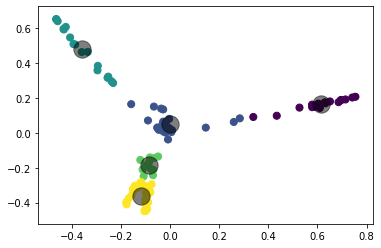

In [276]:
plot_kmeans(km,vect,y_means)

In [232]:

import numpy as np
cluster_0= [i for i, x in enumerate(y_means) if x == 0]
cluster_1= [i for i, x in enumerate(y_means) if x == 1]
cluster_2= [i for i, x in enumerate(y_means) if x == 2]
cluster_3= [i for i, x in enumerate(y_means) if x == 3]
cluster_4= [i for i, x in enumerate(y_means) if x == 4]


Affichage des clusters

In [233]:
print(type(y_means))
print('cluster_0 :')
print(cluster_0)
print('\ncluster_1 :')
print(cluster_1)
print('\cluster_2 :')
print(cluster_2)
print('\cluster_3 :')
print(cluster_3)
print('\cluster_4 :')
print(cluster_4)

<class 'numpy.ndarray'>
cluster_0 :
[2, 7, 12, 17, 22, 27, 32, 37, 42, 47, 52, 62, 67, 72, 77, 92, 97]

cluster_1 :
[1, 6, 11, 16, 18, 21, 23, 26, 31, 36, 41, 46, 51, 56, 57, 61, 66, 71, 76, 81, 82, 86, 87, 91, 93, 96]
\cluster_2 :
[3, 8, 13, 28, 33, 38, 43, 48, 53, 58, 63, 68, 73, 78, 83, 88, 98]
\cluster_3 :
[0, 5, 19, 29, 30, 40, 45, 60, 64, 65, 75, 94]
\cluster_4 :
[4, 9, 10, 14, 15, 20, 24, 25, 34, 35, 39, 44, 49, 50, 54, 55, 59, 69, 70, 74, 79, 80, 84, 85, 89, 90, 95, 99]


Classer les documents dans chaque cluster en fonction de leurs similarités avec leur centroid (4 classe:....)
Comparer les resultats obtenus avec les annotation preetablies 

## 3.2 k-means avec SVD

In [315]:
def cluster_class(cluster,vect,centroid):
    
    list_doc = []
    for doc in cluster:
        distance = euclidean_distances([vect[doc]],[centroid])
        list_doc.append((doc,distance[0][0]))
    
    list_doc.sort(key=lambda x:x[1])
    classe_1 = list_doc[:int(len(list_doc)/4)]
    classe_2 = list_doc[int(len(list_doc)/4):int(len(list_doc)/2)]
    classe_3 = list_doc[int(len(list_doc)/2):int(3*len(list_doc)/4)]
    classe_4 = list_doc[int(3*len(list_doc)/4):]
    
    print("les plus similaire : ",[doc[0] for doc in classe_1])
    print("les similaire : ",[doc[0] for doc in classe_2])
    print("les non similaire : ",[doc[0] for doc in classe_3])
    print("les plus non similaire : ",[doc[0] for doc in classe_4])


In [334]:
from sklearn.metrics.pairwise import euclidean_distances

def kmeans_svd():
    
    #predetermination des centroids
    centroids=np.array([[-0.04880332, -0.13545292],[-0.08478918, -0.32849088],[-0.07533928, -0.29461523],[-0.10103029, -0.43603364],[-0.09778941, -0.44609495]])
    km = KMeans(n_clusters=5, init=centroids,n_init=100)

    vect=docVectSVD(get_corpus())
    vect = np.array(vect)
    km.fit(vect)
    y_means = km.predict(vect)
    
    centroid = km.cluster_centers_
    print("les centers :")
    print(centroid)
    
    print("\n affichage :")
    plot_kmeans(km,vect,y_means)
    
    # classification des documents dans chaque cluser avec disatnce euclidienne
    cluster_0 = [i for i, x in enumerate(y_means) if x == 0]
    cluster_1 = [i for i, x in enumerate(y_means) if x == 1]
    cluster_2 = [i for i, x in enumerate(y_means) if x == 2]
    cluster_3 = [i for i, x in enumerate(y_means) if x == 3]
    cluster_4 = [i for i, x in enumerate(y_means) if x == 4]
    
    print("\ncluster 0 :")
    print(cluster_0)
    cluster_class(cluster_0,vect,centroid[0])
    print("\ncluster 1 :")
    print(cluster_1)
    cluster_class(cluster_1,vect,centroid[1])
    print("\ncluster 2 :")
    print(cluster_2)
    cluster_class(cluster_2,vect,centroid[2])
    print(cluster_3)
    print("\ncluster 3 :")
    cluster_class(cluster_3,vect,centroid[3])


les centers :
[[ 0.89317727 -0.16298561]
 [ 0.6538317   0.70448149]
 [ 0.74233146  0.6182251 ]
 [ 0.7843469   0.55210116]
 [ 0.82884589  0.42281772]]

 affichage :


/home/mohcin/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=100.
  self._check_params(X)


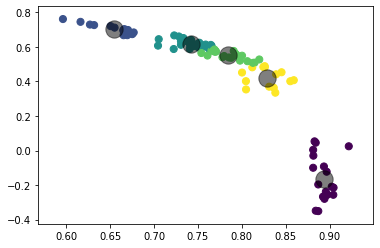


cluster 0 :
[3, 8, 13, 18, 23, 28, 33, 38, 43, 48, 53, 58, 63, 68, 73, 78, 83, 88, 98]
les plus similaire :  [33, 28, 48, 13]
les similaire :  [23, 3, 83, 98, 43]
les non similaire :  [63, 8, 78, 68, 38]
les plus non similaire :  [73, 53, 18, 58, 88]

cluster 1 :
[2, 7, 12, 22, 27, 32, 37, 42, 47, 52, 62, 67, 82, 92, 97]
les plus similaire :  [7, 27, 62]
les similaire :  [2, 67, 97, 32]
les non similaire :  [52, 42, 82, 22]
les plus non similaire :  [37, 47, 12, 92]

cluster 2 :
[5, 9, 10, 14, 15, 16, 17, 21, 24, 25, 34, 35, 39, 40, 44, 49, 50, 54, 59, 60, 69, 72, 74, 75, 77, 79, 80, 87, 90, 94]
les plus similaire :  [79, 87, 10, 25, 54, 90, 40]
les similaire :  [74, 14, 44, 15, 16, 35, 39, 94]
les non similaire :  [59, 69, 80, 9, 21, 24, 34]
les plus non similaire :  [75, 50, 49, 77, 72, 5, 17, 60]
[1, 4, 11, 19, 20, 29, 30, 45, 55, 56, 57, 65, 66, 70, 71, 76, 84, 85, 89, 91, 95, 99]

cluster 3 :
les plus similaire :  [89, 29, 11, 30, 55]
les similaire :  [56, 76, 65, 84, 20, 70]
les

In [335]:
kmeans_svd()

## 3.3 k-means avec Word2Vec


In [336]:
def kmeans_w2v():
    #predetermination des centroids
    centroids=np.array([[-0.04880332, -0.13545292],[-0.08478918, -0.32849088],[-0.07533928, -0.29461523],[-0.10103029, -0.43603364],[-0.09778941, -0.44609495]])
    km = KMeans(n_clusters=5, init=centroids,n_init=100)

    vect = propreDocWV(get_corpus(),vector_size=2)
    vect = np.array(vect)
    km.fit(vect)
    y_means = km.predict(vect)
    
    centroid = km.cluster_centers_
    print("les centers :")
    print(centroid)
    
    print("\n affichage :")
    plot_kmeans(km,vect,y_means)
    
    # classification des documents dans chaque cluser avec disatnce euclidienne
    cluster_0 = [i for i, x in enumerate(y_means) if x == 0]
    cluster_1 = [i for i, x in enumerate(y_means) if x == 1]
    cluster_2 = [i for i, x in enumerate(y_means) if x == 2]
    cluster_3 = [i for i, x in enumerate(y_means) if x == 3]
    cluster_4 = [i for i, x in enumerate(y_means) if x == 4]
    
    print("\ncluster 0 :")
    print(cluster_0)
    cluster_class(cluster_0,vect,centroid[0])
    print("\ncluster 1 :")
    print(cluster_1)
    cluster_class(cluster_1,vect,centroid[1])
    print("\ncluster 2 :")
    print(cluster_2)
    cluster_class(cluster_2,vect,centroid[2])
    print(cluster_3)
    print("\ncluster 3 :")
    cluster_class(cluster_3,vect,centroid[3])







les centers :
[[0.5917638  0.2746224 ]
 [1.2123127  0.57872474]
 [1.0263618  0.5212216 ]
 [0.904127   0.4375255 ]
 [0.7549806  0.36022276]]

 affichage :


/home/mohcin/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=100.
  self._check_params(X)


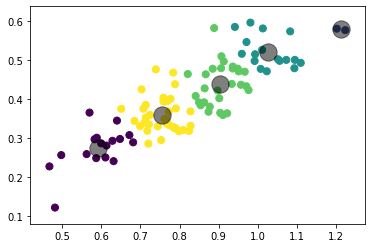


cluster 0 :
[5, 16, 18, 19, 21, 23, 30, 40, 56, 57, 60, 65, 66, 68, 76, 88, 93]
les plus similaire :  [30, 68, 40, 16]
les similaire :  [56, 5, 19, 23]
les non similaire :  [57, 21, 66, 60]
les plus non similaire :  [65, 76, 93, 88, 18]

cluster 1 :
[53, 73]
les plus similaire :  []
les similaire :  [53]
les non similaire :  []
les plus non similaire :  [73]

cluster 2 :
[2, 8, 22, 27, 32, 37, 43, 48, 52, 62, 63, 69, 77, 78, 83, 92, 98]
les plus similaire :  [77, 63, 32, 83]
les similaire :  [48, 2, 43, 98]
les non similaire :  [27, 52, 62, 78]
les plus non similaire :  [37, 69, 8, 22, 92]
[7, 9, 13, 14, 15, 17, 24, 25, 33, 38, 39, 42, 47, 49, 51, 54, 58, 61, 67, 70, 72, 74, 79, 81, 84, 89, 97, 99]

cluster 3 :
les plus similaire :  [9, 13, 81, 61, 51, 47, 38]
les similaire :  [17, 49, 7, 42, 33, 97, 99]
les non similaire :  [14, 79, 89, 54, 70, 67, 39]
les plus non similaire :  [15, 24, 25, 84, 74, 58, 72]


In [337]:
kmeans_w2v()

## 3.3 k-means avec Doc2Vec

In [338]:
def kmeans_w2v():
    #predetermination des centroids
    centroids=np.array([[-0.04880332, -0.13545292],[-0.08478918, -0.32849088],[-0.07533928, -0.29461523],[-0.10103029, -0.43603364],[-0.09778941, -0.44609495]])
    km = KMeans(n_clusters=5, init=centroids,n_init=100)

    vect = vectorsDoc2Vec(get_corpus(),vector_size=2)
    vect = np.array(vect)
    km.fit(vect)
    y_means = km.predict(vect)
    
    centroid = km.cluster_centers_
    print("les centers :")
    print(centroid)
    
    print("\n affichage :")
    plot_kmeans(km,vect,y_means)
    
    # classification des documents dans chaque cluser avec disatnce euclidienne
    cluster_0 = [i for i, x in enumerate(y_means) if x == 0]
    cluster_1 = [i for i, x in enumerate(y_means) if x == 1]
    cluster_2 = [i for i, x in enumerate(y_means) if x == 2]
    cluster_3 = [i for i, x in enumerate(y_means) if x == 3]
    cluster_4 = [i for i, x in enumerate(y_means) if x == 4]
    
    print("\ncluster 0 :")
    print(cluster_0)
    cluster_class(cluster_0,vect,centroid[0])
    print("\ncluster 1 :")
    print(cluster_1)
    cluster_class(cluster_1,vect,centroid[1])
    print("\ncluster 2 :")
    print(cluster_2)
    cluster_class(cluster_2,vect,centroid[2])
    print(cluster_3)
    print("\ncluster 3 :")
    cluster_class(cluster_3,vect,centroid[3])

/home/mohcin/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=100.
  self._check_params(X)


les centers :
[[-1.1313844  1.0804869]
 [-2.5627487  3.183317 ]
 [-2.2527633  2.4435894]
 [-2.0285218  1.8355844]
 [-1.3457503  2.0887966]]

 affichage :


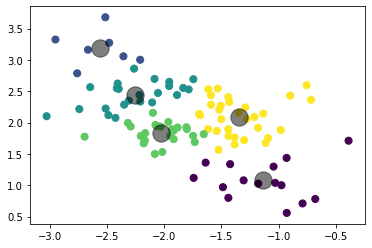


cluster 0 :
[13, 14, 16, 18, 21, 22, 23, 24, 37, 38, 69, 70, 72, 73, 74]
les plus similaire :  [74, 37, 21]
les similaire :  [23, 72, 16, 14]
les non similaire :  [70, 69, 24, 22]
les plus non similaire :  [18, 38, 13, 73]

cluster 1 :
[5, 40, 55, 66, 86, 96, 99]
les plus similaire :  [96]
les similaire :  [5, 99]
les non similaire :  [86, 66]
les plus non similaire :  [55, 40]

cluster 2 :
[20, 28, 29, 30, 34, 35, 36, 41, 44, 45, 47, 62, 64, 65, 75, 76, 79, 80, 84, 85, 88, 93, 95]
les plus similaire :  [85, 95, 45, 64, 79]
les similaire :  [62, 76, 29, 93, 28, 65]
les non similaire :  [35, 80, 88, 84, 20, 34]
les plus non similaire :  [75, 44, 47, 41, 30, 36]
[0, 1, 3, 4, 6, 7, 9, 10, 11, 19, 25, 26, 31, 46, 50, 51, 52, 56, 58, 61, 67, 71, 89, 91]

cluster 3 :
les plus similaire :  [4, 7, 11, 71, 61, 1]
les similaire :  [0, 51, 58, 6, 9, 52]
les non similaire :  [26, 25, 31, 3, 67, 56]
les plus non similaire :  [10, 50, 89, 91, 19, 46]


In [339]:
kmeans_w2v()